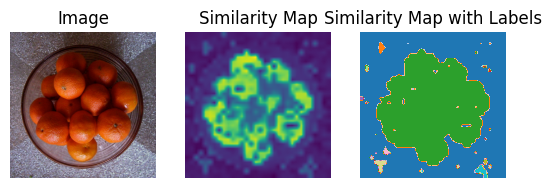

In [11]:
### Semantic
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from zip_utils import *

model, _ = clip.load("CS-ViT-B/16")
model.eval().cuda()
img_path = "__assets__/example1.png"
I = Image.open(img_path).convert('RGB')
plt.subplot(1, 3, 1)
ax = plt.gca()
ax.set_axis_off()
ax.title.set_text('Image')
plt.imshow(I)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tensor = H2_ToTensor(I).unsqueeze(0)
tensor = tensor.cuda()

all_texts =['orange']
with torch.no_grad():
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, 'cuda')

all_texts =['']
with torch.no_grad():
    redundant_feats = clip.encode_text_with_prompt_ensemble(model, all_texts, 'cuda')

with torch.no_grad():
    image_features0 = model.encode_image(tensor)
    image_features0 = image_features0 / image_features0.norm(dim=1, keepdim=True)
    similarity0 = clip.clip_feature_surgery(image_features0, text_features, redundant_feats)
    similarity_map0 = clip.get_similarity_map(similarity0[:, 1:, :], image.shape[:2]).squeeze(0)
    similarity_map0 = similarity_map0.cpu().numpy()
    plt.subplot(1, 3, 2)
    ax = plt.gca()
    ax.set_axis_off()
    ax.title.set_text('Similarity Map')
    plt.imshow(similarity_map0)
    threshold = np.mean(similarity_map0) * 0.7

    class_act_resize = np.asarray(similarity_map0) > np.asarray(threshold)
    labels = measure.label(class_act_resize, connectivity=2, background=0)
    properties = measure.regionprops(labels)
    cmap = plt.get_cmap('tab20', len(properties)+1)
    plt.subplot(1, 3, 3)
    ax = plt.gca()
    ax.set_axis_off()
    ax.title.set_text('Similarity Map with Labels')
    plt.imshow(labels, cmap=cmap,vmin=0, vmax=len(properties))


In [2]:
model_, _ = clip.load("RN50x64")
model_ = list(model_.visual.children())
l_backbone = nn.Sequential(*(model_[:-2])).float()

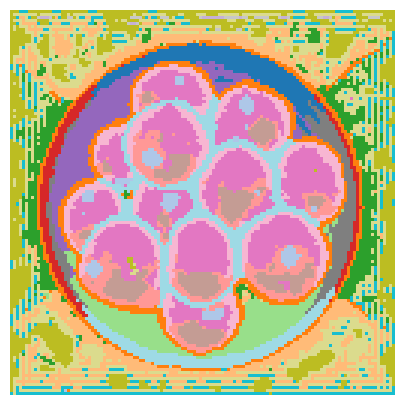

In [29]:
### Clustering
with torch.no_grad():
    tensor = L_ToTensor(I).unsqueeze(0)
    tensor = tensor.cuda()
    feature = l_backbone(tensor)[0]
    c, h, w = feature.shape
    feature_flat = feature.permute(1, 2, 0).reshape(-1, c)
    k = 20
    centroid_indices = torch.randint(feature_flat.shape[0], size=(k,))
    centroid_indices = centroid_indices.cuda()
    new_centroids = feature_flat[centroid_indices]

    max_iterations = 100
    for i in range(max_iterations):
        distances = torch.cdist(feature_flat, new_centroids, p=2)
        cluster_indices = torch.argmin(distances, dim=1)
        old_centroids = new_centroids.clone()
        for j in range(k):
            mask = cluster_indices == j
            cluster_points = feature_flat[mask]
            if len(cluster_points) > 0:
                new_centroids[j] = cluster_points.mean(dim=0)
            else:
                new_centroids[j] = old_centroids[j]
        if torch.allclose(new_centroids, old_centroids, rtol=1e-5):
            break
    cluster_labels = cluster_indices.reshape(feature.shape[1], feature.shape[2])
    cluster_labels = cluster_labels.cpu().numpy()
    cluster_labels = cluster_labels + 1
    cmap = plt.get_cmap('tab20', np.max(cluster_labels)+1)
    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.set_axis_off()
    plt.imshow(cluster_labels, cmap=cmap)

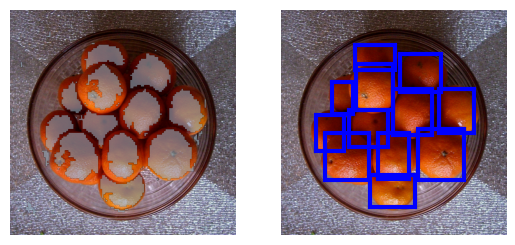

In [30]:
#### Combine
from zip_utils import *

class_act = similarity_map0[..., 0]
threshold = np.mean(class_act) * 0.7
class_act_resize = F.interpolate(torch.tensor(class_act).unsqueeze(0).unsqueeze(0).float(), size=cluster_labels.shape, mode='nearest').squeeze(0).squeeze(0).cpu().numpy()
class_act_resize = np.asarray(class_act_resize) > np.asarray(threshold)
cluster_labels_class = cluster_labels * class_act_resize

counter = Counter(np.asarray(cluster_labels_class.flatten()))
overall_map = np.float64(cluster_labels == -1)
for sub_class, sub_num in counter.most_common(20):
    if sub_class == 0 or sub_class in [-1]:
        continue
    else:
        specific_map = np.float64(cluster_labels == sub_class)
        specific_map_instance = measure.label(specific_map, connectivity=1, background=0)
        properties = measure.regionprops(specific_map_instance)
        for prop in properties:
            if prop.label == 0:
                continue
            i = prop.label
            instance_map = np.float64(specific_map_instance == i)
            gain1 = np.sum(instance_map * class_act_resize) / np.sum(instance_map)
            loss1 = bbox_area(prop.bbox) / prop.area
            # print(loss1)
            if  (gain1 > 0.3 and loss1 < 3):
                overall_map = overall_map + instance_map
                
labels = measure.label(overall_map != 0, connectivity=1, background=0)
draw_labels = overall_map != 0
draw_labels_resize = F.interpolate(torch.tensor(draw_labels).unsqueeze(0).unsqueeze(0).float(), size=(I.size[1], I.size[0]), mode='nearest').squeeze(0).squeeze(0).cpu().numpy()
camp = plt.get_cmap('tab20', np.max(labels))
plt.subplot(1, 2, 1)
plt.imshow(image)
show_mask(draw_labels_resize, plt.gca(), random_color=False)
ax = plt.gca()
ax.set_axis_off()

plt.subplot(1, 2, 2)
plt.imshow(image)
ax = plt.gca()
ax.set_axis_off()
scale1 = I.size[0] / labels.shape[0]
scale2 = I.size[1] / labels.shape[1]
properties = measure.regionprops(labels)
for prop in properties:
    if prop.area < 100:
        continue
    resize_bbox = [prop.bbox[1]*scale1, prop.bbox[0]*scale2, prop.bbox[3]*scale1, prop.bbox[2]*scale2]
    show_box(resize_bbox, plt.gca())

In [1]:
from zip_utils import *
model, _ = clip.load("CS-ViT-B/16")
model.eval().cuda()
model_, _ = clip.load("RN50x64")
model_ = list(model_.visual.children())
l_backbone = nn.Sequential(*(model_[:-2])).float()

/root/anaconda3/envs/ovd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 3, 512, 512])


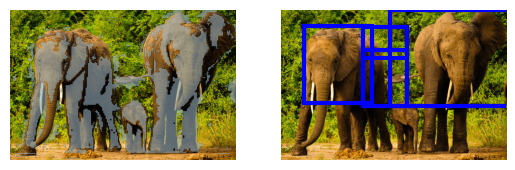

In [45]:
inference_on_one_image(model, l_backbone, "__assets__/example2.png", ['elephant'])